开始拉取数据(按年)...
筛选到 2020–2025 年数据 ✅，共 110010 根 5m K 线，交易日 ≈ 1415 天

=== 每年年初QQQ价格（基于当年首个交易日 RTH 的最后一根5m收盘）===
2020: 22.71
2021: 43.47
2022: 85.61
2023: 16.91
2024: 48.13
2025: 78.59

开始回测(美元盈亏)...
回测完成 ✅，共 1414 笔交易日记录

=== 总体统计（固定 1 股，美元盈亏）===
样本交易数: 1414
总胜率(含EOD): 62.38%
做多胜率: 62.20%
做空胜率: 62.57%
平均单笔盈亏(美元): 0.162
总盈亏(美元): 228.87 (1007.79%)  # 基准: 2020年年初价

=== 分年度统计 ===
2020 | 样本: 253 | 胜率: 55.73% | 做多胜率: 57.24% | 做空胜率: 53.70% | 平均盈亏$: 0.03 | 年度合计$: 7.19 (31.66%) | 年初QQQ价格: 22.71
2021 | 样本: 252 | 胜率: 64.29% | 做多胜率: 62.77% | 做空胜率: 66.09% | 平均盈亏$: 0.21 | 年度合计$: 53.89 (123.97%) | 年初QQQ价格: 43.47
2022 | 样本: 250 | 胜率: 62.40% | 做多胜率: 58.87% | 做空胜率: 65.87% | 平均盈亏$: 0.14 | 年度合计$: 35.76 (41.77%) | 年初QQQ价格: 85.61
2023 | 样本: 250 | 胜率: 62.40% | 做多胜率: 61.76% | 做空胜率: 63.16% | 平均盈亏$: 0.11 | 年度合计$: 28.44 (168.18%) | 年初QQQ价格: 16.91
2024 | 样本: 252 | 胜率: 65.48% | 做多胜率: 67.50% | 做空胜率: 63.64% | 平均盈亏$: 0.23 | 年度合计$: 56.95 (118.33%) | 年初QQQ价格: 48.13
2025 | 样本: 157 | 胜率: 64.97% | 做多胜率: 67.86% | 做空胜率: 61.64% |

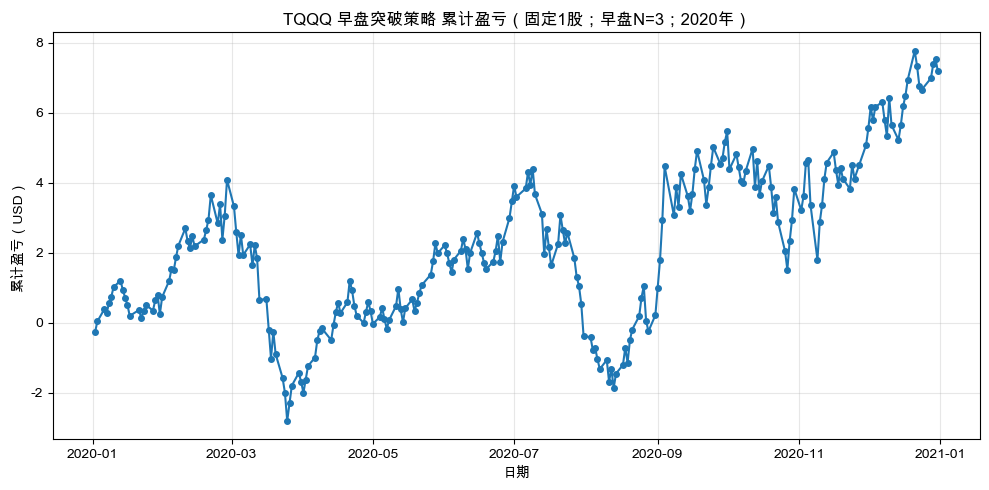

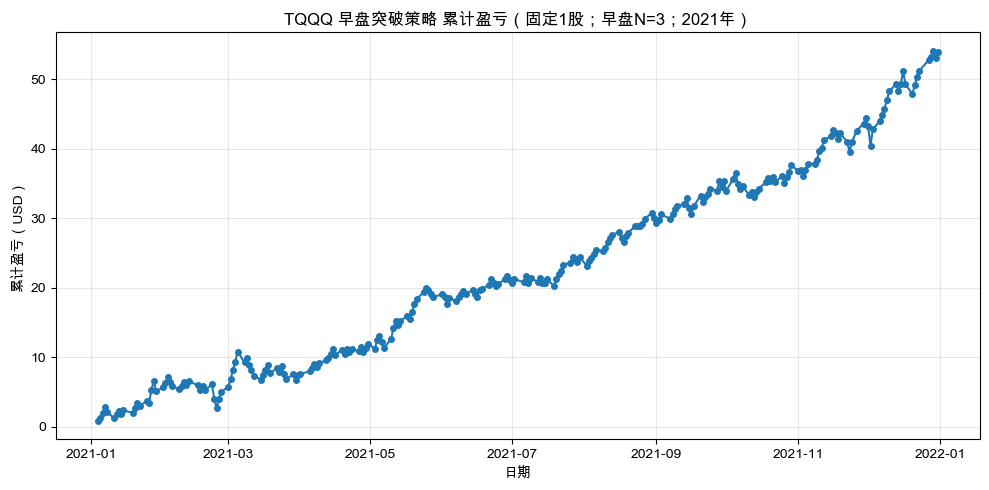

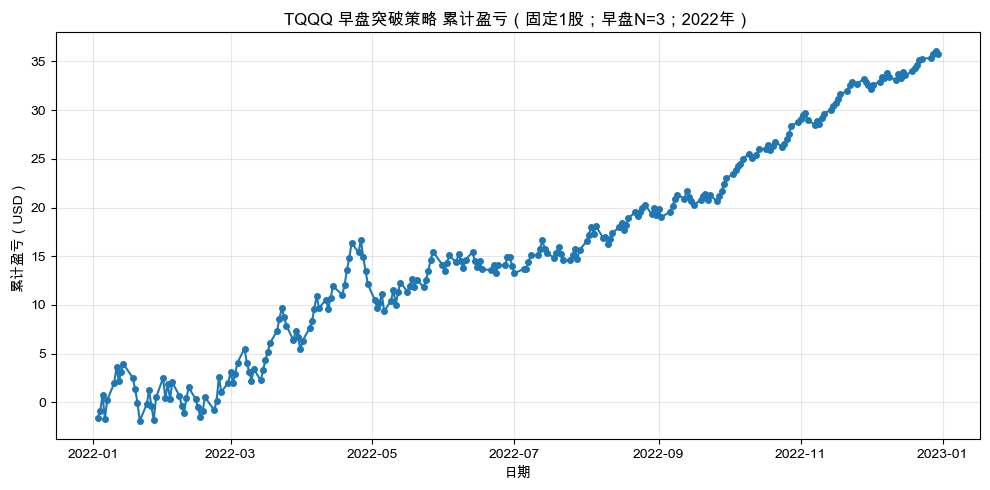

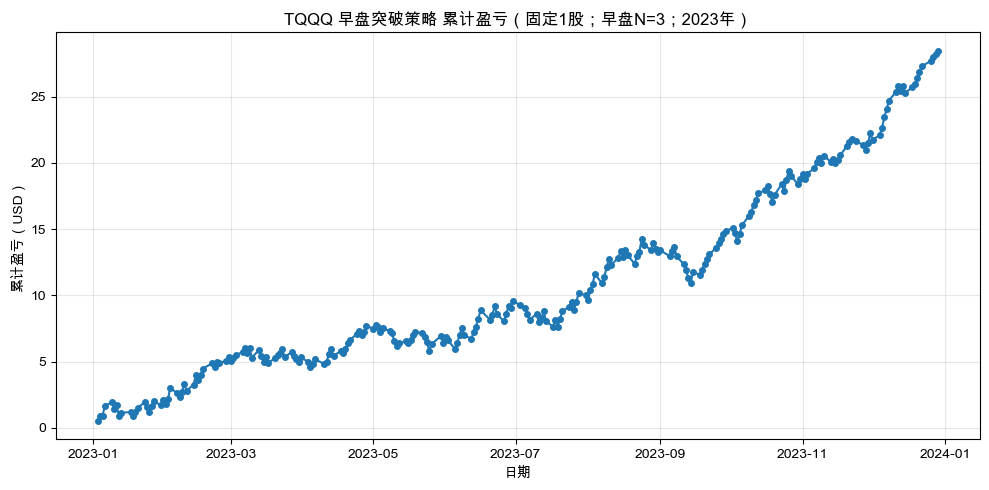

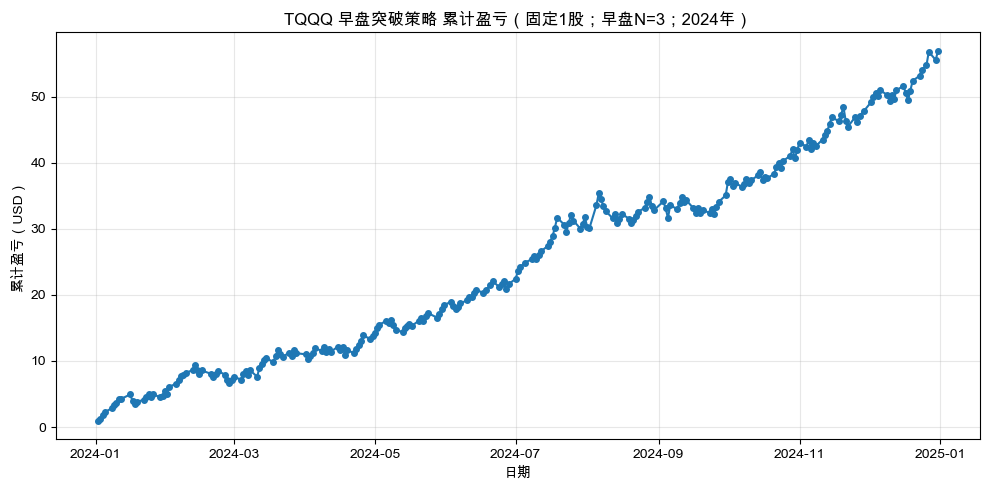

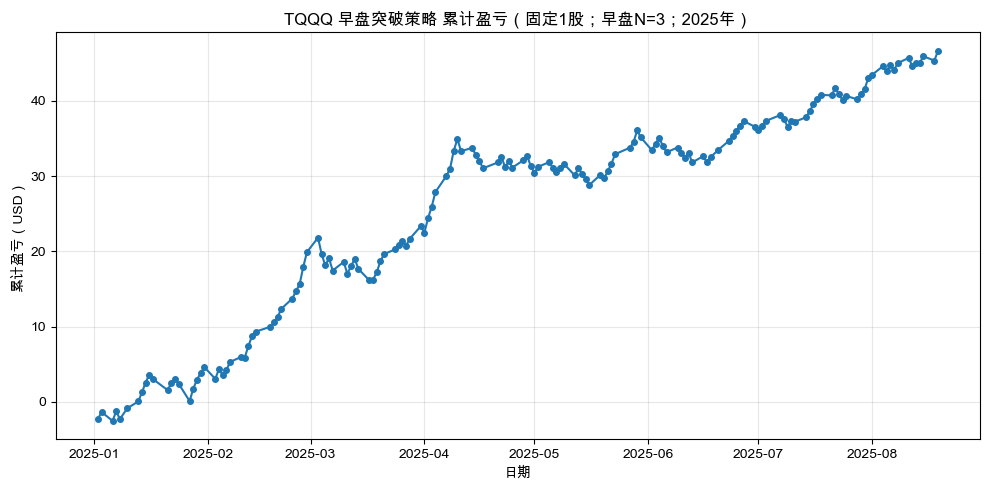

In [32]:
# QQQ 早盘突破策略（按年抓取、按年统计、按年画图）
# ------------------------------------------------------------
# 功能：
# 1) 通过 IBKR 拉取 5 分钟历史数据（只取 RTH），按“早盘 N 根K线区间”做突破策略；
# 2) 仅交易“当天首次突破”（上破或下破其一），入场价用“早盘框边缘价”（多=early_high，空=early_low），
#    止盈/止损默认 = 早盘区间 * RANGE_MULTIPLE（RANGE_MULTIPLE=1 时盈亏比为 1:1）；
# 3) 若当天未触发止盈/止损，则以“日内最后一根 5m K 线的收盘价”平仓（EOD）。
# 4) 统计：打印总体统计 & “逐年统计”；并打印“每年年初的 QQQ 价格（基准价）”；绘图按年各画一张累计盈亏图。
# ------------------------------------------------------------

import warnings
warnings.filterwarnings('ignore')

import time
import random
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ib_insync import *

# ====== Matplotlib（可选中文显示）======
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# ====================== 配置 ======================
HOST = '127.0.0.1'
PORT = 4001                      # 你的 IB Gateway / TWS 端口
CLIENT_ID = random.randint(1, 99999)  # 随机 clientId，避免和其它程序冲突
SYMBOL = 'TQQQ'
BAR_SIZE = '5 mins'              # 固定 5m
USE_RTH = True                   # 只用常规交易时段

LOOKBACK_YEARS = 1               # ✅ 今年往前 N 年（含今年）
N_EARLY_BARS = 3                 # 早盘区间根数
RANGE_MULTIPLE = 1.0             # 止盈/止损倍数（=早盘区间 * 该倍数）
INTRABAR_HIT_ORDER = 'target_first'  # 'stop_first' 或 'target_first'
SLIPPAGE = 0.00                  # 入/出场滑点（正数）；多=+slip，空=-slip（见下文）

# ============= 连接 IBKR & 合约校验（减少历史查询歧义/超时） =============
ib = IB()
ib.connect(HOST, PORT, clientId=CLIENT_ID)

# 关键点：声明 primaryExchange，避免 SMART 合约歧义导致的历史数据“空/超时”
contract = Stock(SYMBOL, 'SMART', 'USD', primaryExchange='NASDAQ')
ib.qualifyContracts(contract)

# ====================== 数据获取（按年 -> 60天批量向前翻）======================
def fetch_5min_data(contract: Contract, lookback_years: int, useRTH: bool = True) -> pd.DataFrame:
    """
    简化策略：按“年数”估算所需交易日（≈每年 252 天），
    然后用 IB 的 reqHistoricalData 按“60 天/批”从最近往前翻，直到覆盖够年数或取不到为止。
    """
    bars_all = []
    total_days = lookback_years * 252      # 粗略估算交易日数
    days_remaining = total_days
    end_time = ''                          # 空字符串=以“现在”为结束点

    while days_remaining > 0:
        batch_days = min(60, days_remaining)  # ✅ 一次只取 60 天，稳定且简单
        try:
            batch = ib.reqHistoricalData(
                contract,
                endDateTime=end_time,
                durationStr=f'{batch_days} D',
                barSizeSetting=BAR_SIZE,
                whatToShow='TRADES',
                useRTH=useRTH,
                formatDate=1
            )
        except Exception as e:
            print(f'⚠️ reqHistoricalData 异常：{e}；提前结束')
            break

        if not batch:
            print('⚠️ 没拉到更多数据，提前结束（可能是权限/网络/节流/pacing）')
            break

        # 关键点：把“更旧”的批次放到前面，保持时间先旧后新
        bars_all = batch + bars_all

        # 更新 end_time 到当前批次中“最早一根”的时间，下一轮继续往更早翻
        oldest_ts = pd.to_datetime(batch[0].date)
        end_time = oldest_ts.strftime('%Y%m%d %H:%M:%S')

        days_remaining -= batch_days
        time.sleep(0.2)  # 小睡，降低被节流概率

    df = util.df(bars_all)
    if df is None or df.empty:
        return pd.DataFrame(columns=['date','open','high','low','close','volume','average','barCount','datetime','Date'])

    df['datetime'] = pd.to_datetime(df['date'])
    df['Date'] = df['datetime'].dt.date
    return df

# ====================== 拉数 & 年份裁剪 ======================
YEAR_END = datetime.now().year
YEAR_START = YEAR_END - LOOKBACK_YEARS + 1

print('开始拉取数据(按年)...')
df = fetch_5min_data(contract, LOOKBACK_YEARS, USE_RTH)
if df.empty:
    raise RuntimeError('未获取到 K 线数据，请检查：\n- IB 是否登录并连接\n- 历史数据权限（US/NASDAQ）\n- 端口/网络是否正常')

# 保险起见：再按年份范围裁一遍（确保刚好是 YEAR_START–YEAR_END）
df = df[(df['datetime'].dt.year >= YEAR_START) & (df['datetime'].dt.year <= YEAR_END)]
print(f'筛选到 {YEAR_START}–{YEAR_END} 年数据 ✅，共 {len(df)} 根 5m K 线，交易日 ≈ {df["Date"].nunique()} 天')

# ====================== 计算“每年年初的 QQQ 价格” ======================
# 关键点：用“该年首个交易日 RTH 的‘日内最后一根 5m bar 的收盘价’”近似为“年初价”
daily_last_close = df.sort_values('datetime').groupby('Date').tail(1)[['Date', 'close', 'datetime']]
daily_last_close['year'] = pd.to_datetime(daily_last_close['Date']).dt.year

# 找出每年“最早那天”的行，再取其 close 作为“年初价”
year_start_rows = daily_last_close.loc[daily_last_close.groupby('year')['Date'].idxmin()].copy()
year_start_price_map = dict(zip(year_start_rows['year'], year_start_rows['close']))

print('\n=== 每年年初QQQ价格（基于当年首个交易日 RTH 的最后一根5m收盘）===')
for y in sorted(year_start_price_map):
    print(f'{y}: {year_start_price_map[y]:.2f}')

# ================ 回测：入场=框边，止盈/止损=早盘区间*倍数（支持先止损/先止盈）================
def backtest_breakout_cash(df: pd.DataFrame,
                           n_early_bars: int = 3,
                           range_multiple: float = 1.0,
                           intrabar_hit_order: str = 'stop_first',
                           slippage: float = 0.0) -> pd.DataFrame:
    """
    规则：
    - 早盘区间：取日内前 n_early_bars 根的最高/最低；区间宽度 = early_high - early_low
    - 触发：从第 n_early_bars+1 根开始，寻找“第一根 收盘 > early_high（做多）或 收盘 < early_low（做空）”
    - 入场价：不是收盘价！而是“框边”价（多=early_high+slip；空=early_low-slip）
    - 止损：落在对侧框边（多=early_low；空=early_high）
    - 止盈：框边沿方向“推进 区间宽度*range_multiple”（多=early_high + 区间*倍数；空=early_low - 区间*倍数）
    - 出场：逐根检查是否命中 TP/SL；若同根同时命中，按 intrabar_hit_order 决先后；若全天都未触发，EOD 收盘价平仓
    - pnl：固定“1 股”，多=exit-entry，空=entry-exit
    """
    records = []

    for day, day_df in df.groupby('Date'):
        day_df = day_df.sort_values('datetime').reset_index(drop=True)
        if len(day_df) <= n_early_bars:
            continue

        early = day_df.iloc[:n_early_bars]
        session = day_df.iloc[n_early_bars:]

        # ✅ 关键修复：重置索引
        session = session.reset_index(drop=True)

        
        early_high = float(early['high'].max())
        early_low  = float(early['low'].min())
        base_range = early_high - early_low
        if base_range <= 0:
            continue

        # —— 寻找“当天首次突破”的那根（收盘确认）——
        break_idx, direction = None, None
        for i, row in session.iterrows():
            if row['close'] > early_high:
                break_idx, direction = i, 'long'
                break
            if row['close'] < early_low:
                break_idx, direction = i, 'short'
                break
        if break_idx is None:
            continue

        # —— 入场：框边价（可加滑点）/ 止损 / 止盈 —— 
        entry_bar  = session.iloc[break_idx]
        entry_time = entry_bar['datetime']

        if direction == 'long':
            entry_price = early_high + slippage
            stop   = early_low
            target = early_high + base_range * range_multiple
        else:
            entry_price = early_low - slippage
            stop   = early_high
            target = early_low - base_range * range_multiple

        # —— 出场扫描：从入场下一根开始，检查是否命中 TP/SL；否则 EOD —— 
        after = session.iloc[break_idx+1:]
        exit_price, exit_time, outcome = None, None, 'eod'

        for _, bar in after.iterrows():
            bar_high = float(bar['high'])
            bar_low  = float(bar['low'])

            if direction == 'long':
                hit_stop   = (bar_low  <= stop)
                hit_target = (bar_high >= target)
            else:
                hit_stop   = (bar_high >= stop)
                hit_target = (bar_low  <= target)

            if hit_stop and hit_target:
                # 关键点：同一根同时命中时的先后规则（回测粒度=5m，只能近似）
                if intrabar_hit_order == 'stop_first':
                    hit_target = False
                else:
                    hit_stop = False

            if hit_stop:
                exit_price = stop - (slippage if direction == 'long' else -slippage)
                exit_time  = bar['datetime']
                outcome    = 'loss'
                break
            if hit_target:
                exit_price = target - (slippage if direction == 'short' else -slippage)
                exit_time  = bar['datetime']
                outcome    = 'win'
                break

        if exit_price is None:  # EOD 出场
            last_bar   = day_df.iloc[-1]
            exit_price = float(last_bar['close'])
            exit_time  = last_bar['datetime']
            outcome    = 'eod'

        pnl = (exit_price - entry_price) if direction == 'long' else (entry_price - exit_price)

        records.append({
            'Date': day,
            'direction': direction,
            'entry_time': entry_time,
            'entry_price': float(entry_price),
            'stop': float(stop),
            'target': float(target),
            'exit_time': exit_time,
            'exit_price': float(exit_price),
            'outcome': outcome,
            'pnl': float(pnl),             # 单股美元盈亏
            'pnl_per_share': float(pnl)    # 语义一致
        })

    return pd.DataFrame(records)

print('\n开始回测(美元盈亏)...')
trades = backtest_breakout_cash(
    df,
    n_early_bars=N_EARLY_BARS,
    range_multiple=RANGE_MULTIPLE,
    intrabar_hit_order=INTRABAR_HIT_ORDER,
    slippage=SLIPPAGE
)
print(f'回测完成 ✅，共 {len(trades)} 笔交易日记录')

# ====================== 统计 & 打印 ======================
def calc_stats(g: pd.DataFrame, year_start_price: float | None) -> dict:
    """对一组交易（总体或某一年）计算指标；若给了 year_start_price，则返回 sum_pnl 对应百分比"""
    total = len(g)
    wins = (g['pnl'] > 0).sum()
    winrate = wins / total if total > 0 else np.nan

    long_mask = (g['direction'] == 'long')
    short_mask = (g['direction'] == 'short')
    long_wr = ((g['pnl'] > 0) & long_mask).sum() / long_mask.sum() if long_mask.sum() > 0 else np.nan
    short_wr = ((g['pnl'] > 0) & short_mask).sum() / short_mask.sum() if short_mask.sum() > 0 else np.nan

    avg_pnl = g['pnl'].mean()
    sum_pnl = g['pnl'].sum()
    pct = (sum_pnl / year_start_price) if (year_start_price and year_start_price > 0) else np.nan

    return dict(trades=total, winrate=winrate, long_wr=long_wr, short_wr=short_wr,
                avg_pnl=avg_pnl, sum_pnl=sum_pnl, pct=pct)

if not trades.empty:
    trades['Date'] = pd.to_datetime(trades['Date'])
    trades['year'] = trades['Date'].dt.year

    # —— 总体统计（总体的“%”用首年年初价作为参照；若只有一年就等同当年）——
    first_year = int(trades['year'].min())
    overall = calc_stats(trades, year_start_price_map.get(first_year, np.nan))
    print('\n=== 总体统计（固定 1 股，美元盈亏）===')
    print(f"样本交易数: {overall['trades']}")
    print(f"总胜率(含EOD): {overall['winrate']:.2%}" if not np.isnan(overall['winrate']) else '总胜率: n/a')
    print(f"做多胜率: {overall['long_wr']:.2%}" if not np.isnan(overall['long_wr']) else '做多胜率: n/a')
    print(f"做空胜率: {overall['short_wr']:.2%}" if not np.isnan(overall['short_wr']) else '做空胜率: n/a')
    print(f"平均单笔盈亏(美元): {overall['avg_pnl']:.3f}")
    if not np.isnan(overall['pct']):
        print(f"总盈亏(美元): {overall['sum_pnl']:.2f} ({overall['pct']:.2%})  # 基准: {first_year}年年初价")
    else:
        print(f"总盈亏(美元): {overall['sum_pnl']:.2f}")

    # —— 分年度统计：含“该年年初QQQ价格” & “年度合计占比%”——
    print('\n=== 分年度统计 ===')
    for y, g in trades.groupby('year'):
        y = int(y)
        y_base = year_start_price_map.get(y, np.nan)  # 该年年初价
        s = calc_stats(g, y_base)
        base_str = f"{y_base:.2f}" if not np.isnan(y_base) else "n/a"
        pct_str  = f"{s['pct']:.2%}" if not np.isnan(s['pct']) else "n/a"
        print(f"{y} | 样本: {s['trades']} | 胜率: {s['winrate']:.2%} | "
              f"做多胜率: {s['long_wr']:.2%} | 做空胜率: {s['short_wr']:.2%} | "
              f"平均盈亏$: {s['avg_pnl']:.2f} | 年度合计$: {s['sum_pnl']:.2f} "
              f"({pct_str}) | 年初QQQ价格: {base_str}")

# ====================== 按年画累计盈亏曲线（点+线） ======================
if not trades.empty:
    for y, g in trades.groupby('year'):
        curve = g.sort_values('Date')[['Date', 'pnl']].copy()
        curve['cum_pnl'] = curve['pnl'].cumsum()

        plt.figure(figsize=(10, 5))
        # 用 marker='o' 显示点，同时用线连起来
        plt.plot(curve['Date'], curve['cum_pnl'], marker='o', linestyle='-', markersize=4)

        plt.title(f'{SYMBOL} 早盘突破策略 累计盈亏（固定1股；早盘N={N_EARLY_BARS}；{int(y)}年）')
        plt.xlabel('日期')
        plt.ylabel('累计盈亏（USD）')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# 断开连接
ib.disconnect()
